In [62]:
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import PIL.Image
import matplotlib.pyplot as plt
import tqdm

## for reproducibility ##
import random
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [63]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setup Data ##

In [64]:
class Image(Dataset):
    def __init__(self, image_path, H=100, W=100):
        super().__init__()
        self.load_image(H=H, W=W)

    def load_image(self, H=100, W=100):
        image_raw = PIL.Image.open('swan.jpg')
        tmp =  PIL.Image.new("RGB", image_raw.size, (255, 255, 255))
        if image_raw.mode == 'RGBA':
            r, g, b, a = image_raw.split()
            tmp.paste(image_raw, (0, 0), mask=a)
        else:
            tmp.paste(image_raw, (0, 0))

        # tmp.paste(image_raw, (0, 0), image_raw)
        image_raw = tmp
        ## augment the image ##tr
        transform =  Compose([Resize([H, W]), ToTensor()])
        self.image_raw = transform(image_raw).to(device)
        self.H = self.image_raw.shape[1]
        self.W = self.image_raw.shape[2]
        self.channel = 3
        self.coords = self.get_coords(self.H, self.W)
        self.labels = self.image_raw.view(1, 3, self.H*self.W).permute(0,2,1)

    def get_coords(self, H, W):
        y_range = ((torch.arange(H,dtype=torch.float32,device=device))/H*2-1)*(H/max(H,W))
        x_range = ((torch.arange(W,dtype=torch.float32,device=device))/W*2-1)*(W/max(H,W))
        Y,X = torch.meshgrid(y_range,x_range) # [H,W]
        xy_grid = torch.stack([X,Y],dim=-1).view(-1,2) # [HW,2]
        xy_grid = xy_grid.repeat(1,1,1) # [B,HW,2]
        return xy_grid

    def __len__(self):
        return self.coords.shape[1]

    def __getitem__(self,idx):
        return self.coords[0, idx], self.labels[0, idx]

In [65]:
H = 100
W = 100
y_range = ((torch.arange(H,dtype=torch.float32,device=device))/H*2-1)*(H/max(H,W))
x_range = ((torch.arange(W,dtype=torch.float32,device=device))/W*2-1)*(W/max(H,W))
Y,X = torch.meshgrid(y_range,x_range) # [H,W]
xy_grid = torch.stack([X,Y],dim=-1).view(-1,2) # [HW,2]
xy_grid = xy_grid.repeat(1,1,1) # [B,HW,2]
print(xy_grid.shape)

torch.Size([1, 10000, 2])


## Models ##

In [66]:
class GaussianLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, sigma=0.05):
        super().__init__()
        self.sigma = sigma
        self.linear = torch.nn.Linear(in_features, out_features)

    def forward(self, input):
        return self.gaussian(self.linear(input))

    def gaussian(self, input):
        """
        Args:
            opt
            x (torch.Tensor [B,num_rays,])
        """
        k1 = (-0.5*(input)**2/self.sigma**2).exp()
        return k1


In [67]:
class ComplexGaborLayer(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega0=10.0, sigma0=40.0,
                 trainable=False):
        super().__init__()
        self.omega_0 = omega0
        self.scale_0 = sigma0
        self.is_first = is_first

        self.in_features = in_features

        if self.is_first:
            dtype = torch.float
        else:
            dtype = torch.cfloat

        # Set trainable parameters if they are to be simultaneously optimized
        self.omega_0 = torch.nn.Parameter(self.omega_0*torch.ones(1), trainable)
        self.scale_0 = torch.nn.Parameter(self.scale_0*torch.ones(1), trainable)

        self.linear = torch.nn.Linear(in_features,
                                out_features,
                                bias=bias,
                                dtype=dtype)

    def forward(self, input):
        lin = self.linear(input)
        omega = self.omega_0 * lin
        scale = self.scale_0 * lin

        return torch.exp(1j*omega - scale.abs().square())


In [68]:
class ReLULayer(torch.nn.Module):
    def __init__(self, in_features, out_features, sigma=0.05):
        super().__init__()
        self.sigma = sigma
        self.linear = torch.nn.Linear(in_features, out_features)
        self.relu = torch.nn.ReLU()

    def forward(self, input):
        return self.relu(self.linear(input))

In [69]:
class GeLULayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        # self.sigma = sigma
        self.linear = torch.nn.Linear(in_features, out_features)
        self.relu = torch.nn.GELU()

    def forward(self, input):
        return self.relu(self.linear(input))

In [70]:
class Sin(torch.nn.Module):
    def __init__(self, inplace: bool = False):
        super(Sin, self).__init__()

    def forward(self, input):
        return torch.sin(input)

class Cos(torch.nn.Module):
    def __init__(self, inplace: bool = False):
        super(Cos, self).__init__()

    def forward(self, input):
        return torch.cos(input)
class consandsinLayer(torch.nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = torch.nn.Linear(in_features, out_features)
        self.sin = Sin()
        self.cos = Cos()
        self.a = torch.nn.Parameter(torch.ones(1))
        self.b = torch.nn.Parameter(torch.ones(1))


    def forward(self, input):
      x = self.linear(input)
      # print("a："+str(self.a))
      # print("b："+str(self.b))
      return self.a*self.sin(x)+self.b*self.cos(x)

# **Gaussian Model**

In [71]:
## Define Gaussian Model
class NeuralGaussianImageFunction(torch.nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_features=256, hidden_layers=4, sigma=0.05):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.sigma = sigma
        self.hidden_layers = hidden_layers
        self.define_network()


    def define_network(self):
        self.mlp = []

        self.mlp.append(GaussianLayer(self.in_features, self.hidden_features, sigma=self.sigma))
        for i in range(self.hidden_layers-1):
            self.mlp.append(GaussianLayer(self.hidden_features, self.hidden_features, sigma=self.sigma))

        self.mlp.append(torch.nn.Linear(self.hidden_features, self.out_features))
        self.mlp = torch.nn.Sequential(*self.mlp)

    def forward(self, input):
        rgb = self.mlp(input)
        return rgb

NeuralGaussianImageFunction(
  (mlp): Sequential(
    (0): GaussianLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): GaussianLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): GaussianLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): GaussianLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


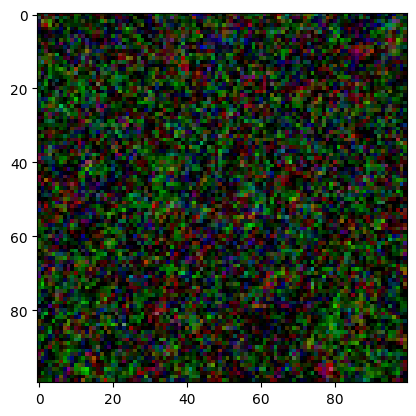

In [72]:
## Init model
model = NeuralGaussianImageFunction(in_features=2, out_features=3, hidden_features=256, hidden_layers=4, sigma=0.05)
model
print(model)

## Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

## Define MSELoss
criterion = torch.nn.MSELoss()


## Visualise initial state
model.eval()
data = Image("swan.jpg")
pred_rgb = model(data.get_coords(H, W))
plt.imshow(pred_rgb[0].reshape(H, W, 3).detach().cpu().numpy())
plt.show()

training:  10%|█         | 20/200 [00:59<08:26,  2.81s/it, it=20, psnr=28.2129]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20.....Test PSNR 29.3682861328125


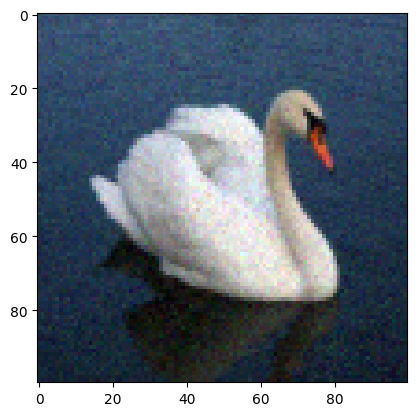

training:  20%|██        | 40/200 [01:58<07:36,  2.85s/it, it=40, psnr=34.2554]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40.....Test PSNR 34.15375900268555


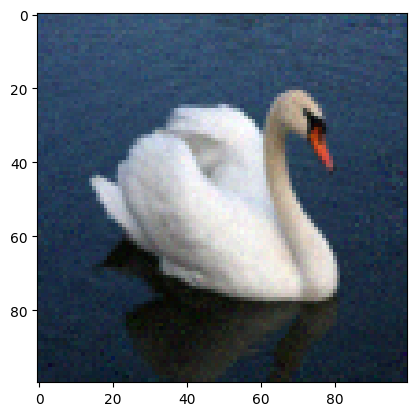

training:  30%|███       | 60/200 [02:56<06:44,  2.89s/it, it=60, psnr=23.4516]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60.....Test PSNR 23.932235717773438


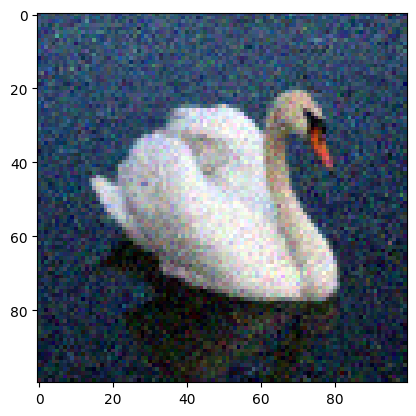

training:  40%|████      | 80/200 [03:54<05:39,  2.83s/it, it=80, psnr=31.4560]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80.....Test PSNR 31.12529945373535


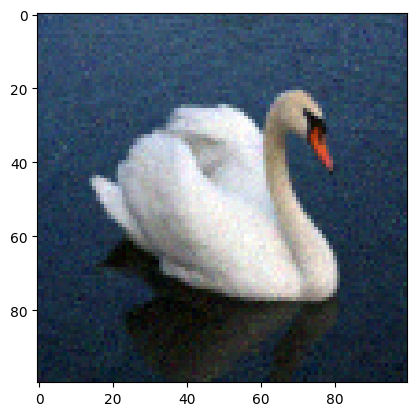

training:  50%|█████     | 100/200 [04:52<05:00,  3.00s/it, it=100, psnr=29.8616]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100.....Test PSNR 29.781517028808594


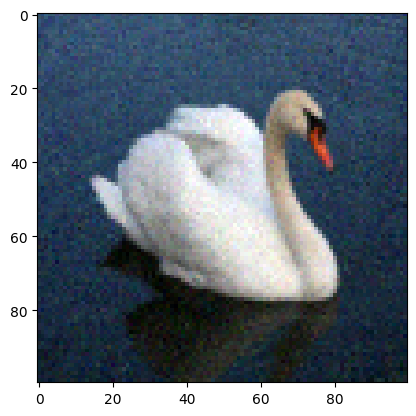

training:  60%|██████    | 120/200 [05:50<03:52,  2.90s/it, it=120, psnr=25.6378]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 120.....Test PSNR 26.395254135131836


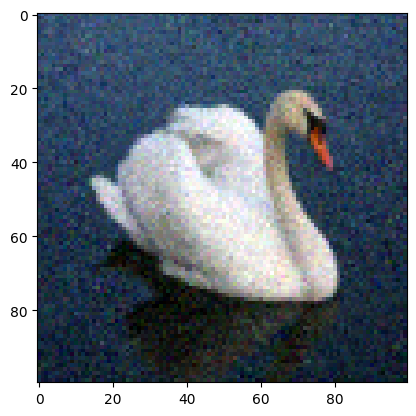

training:  70%|███████   | 140/200 [06:49<02:55,  2.93s/it, it=140, psnr=34.8384]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 140.....Test PSNR 35.00937271118164


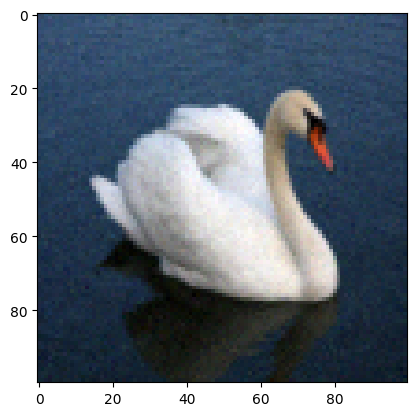

training:  80%|████████  | 160/200 [07:48<01:55,  2.88s/it, it=160, psnr=30.0944]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 160.....Test PSNR 30.191831588745117


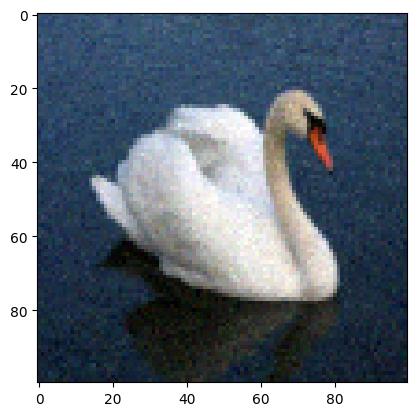

training:  90%|█████████ | 180/200 [08:51<01:00,  3.01s/it, it=180, psnr=22.7577]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 180.....Test PSNR 23.799076080322266


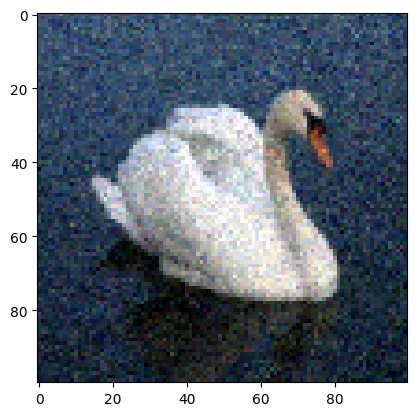

In [73]:
## Setup dataloader
num_epoch = 200
val_freq = 20
model.train()

train_psnrs_Gaussian = []
test_psnrs_Gaussian = []

trainloader = DataLoader(data, batch_size=512, shuffle=True)
progress_loader = tqdm.trange(num_epoch, desc="training", leave=False)


for i in progress_loader:
    for j, (input, gt) in enumerate(trainloader):

        optimizer.zero_grad()
        pred_rgb = model(input)
        loss = criterion(pred_rgb, gt)

        train_psnr = -10 * loss.log10()
        loss.backward()
        optimizer.step()
        progress_loader.set_postfix(it=i,psnr="{:.4f}".format(train_psnr))

    train_psnrs_Gaussian.append(train_psnr)

    if i % val_freq == 0 and i > 0:
        with torch.no_grad():
            val_rgb = model(data.coords)
            loss = criterion(val_rgb, data.labels)
            psnr = -10 * loss.log10()
            test_psnrs_Gaussian.append(psnr)
            print("Epoch {}.....Test PSNR {}".format(i, psnr))
            plt.imshow(val_rgb.view(H,W,3).detach().cpu().numpy())
            plt.show()


# **sin Model**

In [74]:
## Define sin Model
class NeuralSinAndCosImageFunction(torch.nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_features=256, hidden_layers=4):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        self.define_network()


    def define_network(self):
        self.mlp = []

        self.mlp.append(consandsinLayer(self.in_features, self.hidden_features))
        for i in range(self.hidden_layers-1):
            self.mlp.append(consandsinLayer(self.hidden_features, self.hidden_features))

        self.mlp.append(torch.nn.Linear(self.hidden_features, self.out_features))
        self.mlp = torch.nn.Sequential(*self.mlp)

    def forward(self, input):
        rgb = self.mlp(input)
        return rgb

NeuralSinAndCosImageFunction(
  (mlp): Sequential(
    (0): consandsinLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
      (sin): Sin()
      (cos): Cos()
    )
    (1): consandsinLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (sin): Sin()
      (cos): Cos()
    )
    (2): consandsinLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (sin): Sin()
      (cos): Cos()
    )
    (3): consandsinLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
      (sin): Sin()
      (cos): Cos()
    )
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


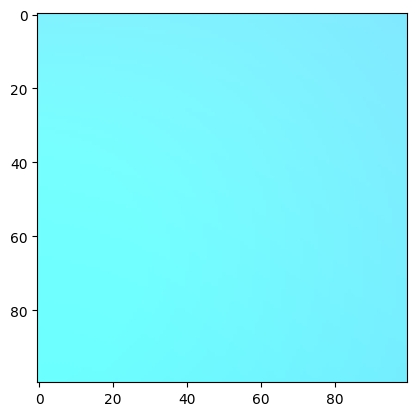

In [75]:
model = NeuralSinAndCosImageFunction(in_features=2, out_features=3, hidden_features=256, hidden_layers=4)
print(model)

## Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

## Define MSELoss
criterion = torch.nn.MSELoss()


## Visualise initial state
model.eval()
data = Image("swan.jpg")
pred_rgb = model(data.coords)
plt.imshow(pred_rgb[0].reshape(H, W, 3).detach().cpu().numpy())
plt.show()

training:  10%|█         | 20/200 [00:16<02:29,  1.20it/s, it=20, psnr=20.6911]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20.....Test PSNR 20.481863021850586


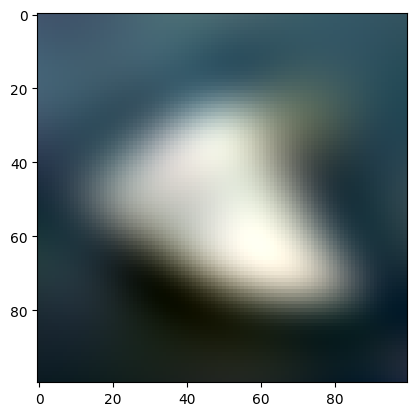

training:  20%|██        | 40/200 [00:31<01:58,  1.35it/s, it=40, psnr=21.8693]

Epoch 40.....Test PSNR 22.853500366210938


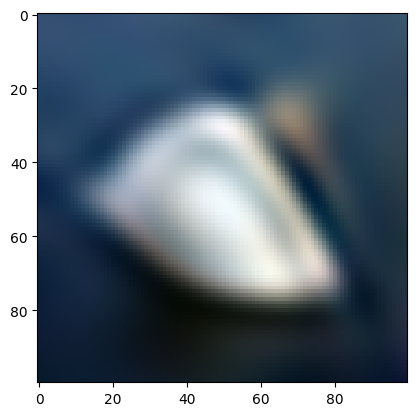

training:  30%|███       | 60/200 [00:46<01:41,  1.37it/s, it=60, psnr=23.8018]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60.....Test PSNR 24.016983032226562


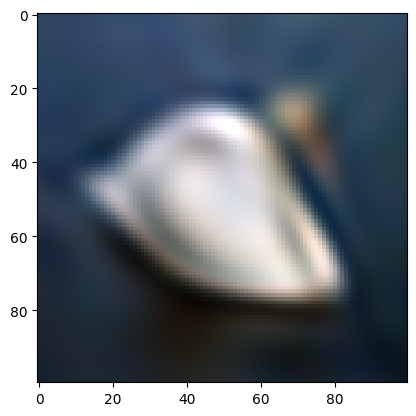

training:  40%|████      | 80/200 [01:01<01:19,  1.50it/s, it=80, psnr=25.8294]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80.....Test PSNR 25.528358459472656


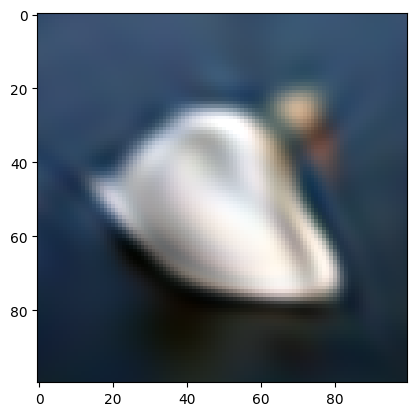

training:  50%|█████     | 100/200 [01:17<01:15,  1.33it/s, it=100, psnr=25.5212]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100.....Test PSNR 26.773208618164062


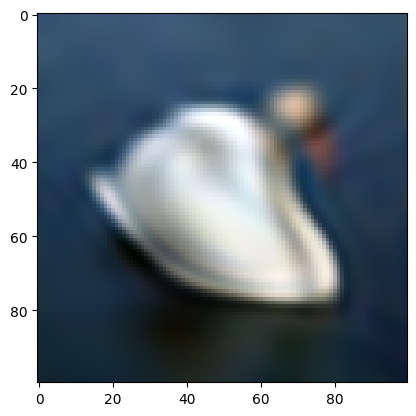

training:  59%|█████▉    | 118/200 [01:32<01:10,  1.16it/s, it=118, psnr=26.2824]

In [ ]:
num_epoch = 200
val_freq = 20
model.train()

train_psnrs_sin = []
test_psnrs_sin = []

trainloader = DataLoader(data, batch_size=512, shuffle=True)
progress_loader = tqdm.trange(num_epoch, desc="training", leave=False)


for i in progress_loader:
    for j, (input, gt) in enumerate(trainloader):
        optimizer.zero_grad()
        pred_rgb = model(input)
        loss = criterion(pred_rgb, gt)

        train_psnr = -10 * loss.log10()
        loss.backward()
        optimizer.step()
        progress_loader.set_postfix(it=i,psnr="{:.4f}".format(train_psnr))

    train_psnrs_sin.append(train_psnr)

    if i % val_freq == 0 and i > 0:
        with torch.no_grad():
            val_rgb = model(data.coords)
            loss = criterion(val_rgb, data.labels)
            psnr = -10 * loss.log10()
            test_psnrs_sin.append(psnr)
            print("Epoch {}.....Test PSNR {}".format(i, psnr))
            plt.imshow(val_rgb.view(H, W, 3).detach().cpu().numpy())
            plt.show()

# **ReLU Model**

In [ ]:
## Define ReLU Model ##
class NeuralReLUImageFunction(torch.nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_features=256, hidden_layers=4, sigma=0.05):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.sigma = sigma
        self.hidden_layers = hidden_layers
        self.define_network()


    def define_network(self):
        self.mlp = []

        self.mlp.append(ReLULayer(self.in_features, self.hidden_features, sigma=self.sigma))
        for i in range(self.hidden_layers-1):
            self.mlp.append(ReLULayer(self.hidden_features, self.hidden_features, sigma=self.sigma))

        self.mlp.append(torch.nn.Linear(self.hidden_features, self.out_features))
        self.mlp = torch.nn.Sequential(*self.mlp)

    def forward(self, input):
        rgb = self.mlp(input)
        return rgb

In [ ]:
## Init model
model = NeuralReLUImageFunction(in_features=2, out_features=3, hidden_features=256, hidden_layers=4, sigma=0.05)
print(model)

## Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

## Define MSELoss
criterion = torch.nn.MSELoss()


## Visualise initial state
model.eval()
data = Image("swan.jpg")
pred_rgb = model(data.coords)
plt.imshow(pred_rgb[0].reshape(H, W, 3).detach().cpu().numpy())
plt.show()

training:  10%|█         | 20/200 [00:12<01:48,  1.66it/s, it=20, psnr=24.0776]

Epoch 20.....Test PSNR 23.640594482421875


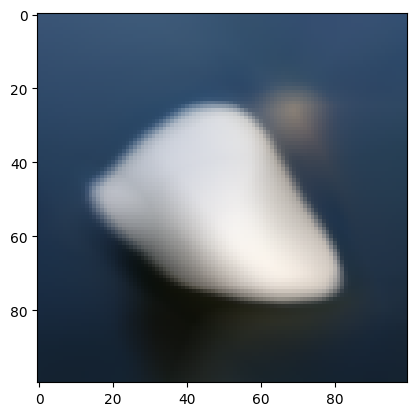

training:  20%|██        | 40/200 [00:24<01:54,  1.40it/s, it=40, psnr=26.5447]

Epoch 40.....Test PSNR 25.829124450683594


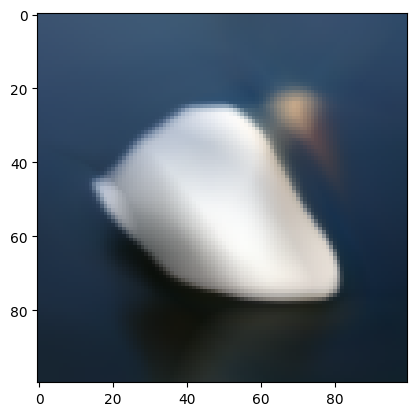

training:  30%|███       | 60/200 [00:36<01:32,  1.52it/s, it=60, psnr=26.3799]

Epoch 60.....Test PSNR 27.380056381225586


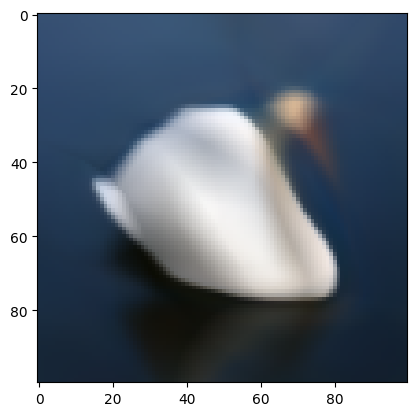

training:  40%|████      | 80/200 [00:49<01:18,  1.53it/s, it=80, psnr=28.9375]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80.....Test PSNR 28.357173919677734


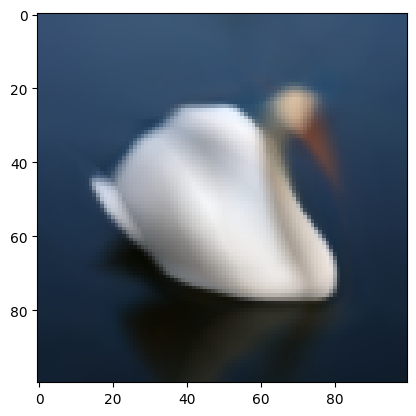

training:  50%|█████     | 100/200 [01:02<01:05,  1.52it/s, it=100, psnr=29.2062]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100.....Test PSNR 29.053590774536133


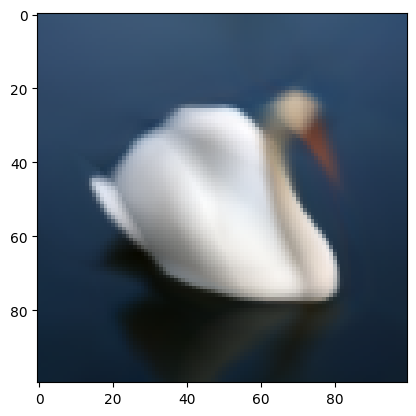

training:  60%|██████    | 120/200 [01:15<00:49,  1.61it/s, it=120, psnr=29.2693]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 120.....Test PSNR 29.864471435546875


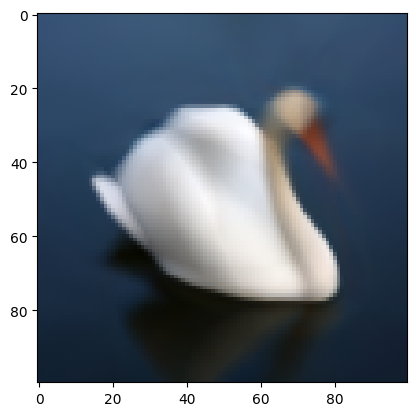

training:  70%|███████   | 140/200 [01:29<00:40,  1.47it/s, it=140, psnr=28.2825]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 140.....Test PSNR 29.503284454345703


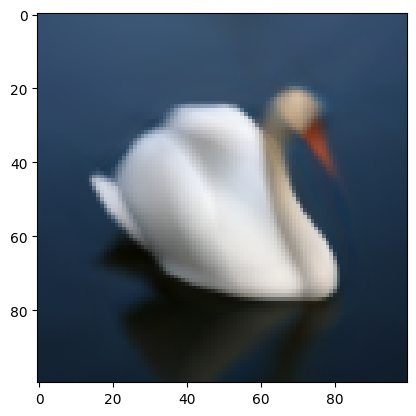

training:  80%|████████  | 160/200 [01:42<00:26,  1.53it/s, it=160, psnr=32.1863]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 160.....Test PSNR 28.74687385559082


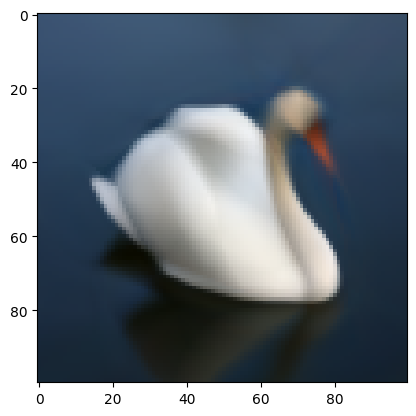

training:  83%|████████▎ | 166/200 [01:46<00:21,  1.55it/s, it=166, psnr=30.7429]

In [ ]:
## Setup dataloader
num_epoch = 200
val_freq = 20
model.train()

train_psnrs_ReLU = []
test_psnrs_ReLU = []

trainloader = DataLoader(data, batch_size=512, shuffle=True)
progress_loader = tqdm.trange(num_epoch, desc="training", leave=False)


for i in progress_loader:
    for j, (input, gt) in enumerate(trainloader):
        optimizer.zero_grad()
        pred_rgb = model(input)
        loss = criterion(pred_rgb, gt)

        train_psnr = -10 * loss.log10()
        loss.backward()
        optimizer.step()
        progress_loader.set_postfix(it=i,psnr="{:.4f}".format(train_psnr))

    train_psnrs_ReLU.append(train_psnr)

    if i % val_freq == 0 and i > 0:
        with torch.no_grad():
            val_rgb = model(data.coords)
            loss = criterion(val_rgb, data.labels)
            psnr = -10 * loss.log10()
            test_psnrs_ReLU.append(psnr)
            print("Epoch {}.....Test PSNR {}".format(i, psnr))
            plt.imshow(val_rgb.view(H, W, 3).detach().cpu().numpy())
            plt.show()

# **GELU Model**

In [ ]:
## Define GeLU Model
class GeluImageFunction(torch.nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_features=256, hidden_layers=4):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers
        self.define_network()


    def define_network(self):
        self.mlp = []

        self.mlp.append(GeLULayer(self.in_features, self.hidden_features))
        for i in range(self.hidden_layers-1):
            self.mlp.append(GeLULayer(self.hidden_features, self.hidden_features))

        self.mlp.append(torch.nn.Linear(self.hidden_features, self.out_features))
        self.mlp = torch.nn.Sequential(*self.mlp)

    def forward(self, input):
        rgb = self.mlp(input)
        return rgb

In [ ]:
model = GeluImageFunction(in_features=2, out_features=3, hidden_features=256, hidden_layers=4)
print(model)

## Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)

## Define MSELoss
criterion = torch.nn.MSELoss()


## Visualise initial state
model.eval()
data = Image("swan.jpg")
pred_rgb = model(data.coords)
plt.imshow(pred_rgb[0].reshape(H, W, 3).detach().cpu().numpy())
plt.show()

In [ ]:
num_epoch = 200
val_freq = 20
model.train()

train_psnrs_gelu = []
test_psnrs_gelu = []

trainloader = DataLoader(data, batch_size=512, shuffle=True)
progress_loader = tqdm.trange(num_epoch, desc="training", leave=False)


for i in progress_loader:
    for j, (input, gt) in enumerate(trainloader):
        optimizer.zero_grad()
        pred_rgb = model(input)
        loss = criterion(pred_rgb, gt)

        train_psnr = -10 * loss.log10()
        loss.backward()
        optimizer.step()
        progress_loader.set_postfix(it=i,psnr="{:.4f}".format(train_psnr))

    train_psnrs_gelu.append(train_psnr)

    if i % val_freq == 0 and i > 0:
        with torch.no_grad():
            val_rgb = model(data.coords)
            loss = criterion(val_rgb, data.labels)
            psnr = -10 * loss.log10()
            test_psnrs_gelu.append(psnr)
            print("Epoch {}.....Test PSNR {}".format(i, psnr))
            plt.imshow(val_rgb.view(H, W, 3).detach().cpu().numpy())
            plt.show()

# **Gabor Model**

In [ ]:
class ComplexImageFunction(torch.nn.Module):
    def __init__(self, in_features=2, out_features=3, hidden_features=256, hidden_layers=4):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_features = hidden_features
        self.hidden_layers = hidden_layers

        # self.hidden_features = int(hidden_features/np.sqrt(2))
        dtype = torch.cfloat
        self.complex = True
        self.wavelet = 'gabor'
        self.define_network()

    def define_network(self):
        self.mlp = []

        self.mlp.append(ComplexGaborLayer(self.in_features, self.hidden_features,omega0=30,sigma0=10,is_first=True,))
        for i in range(self.hidden_layers-1):
            self.mlp.append(ComplexGaborLayer(self.hidden_features, self.hidden_features,omega0=30,sigma0=10))

        self.mlp.append(torch.nn.Linear(self.hidden_features, self.out_features,dtype=torch.cfloat))
        self.mlp = torch.nn.Sequential(*self.mlp)

    def forward(self, input):
        rgb = self.mlp(input)
        if self.wavelet == 'gabor':
            return rgb.real
        return rgb

In [ ]:
model = ComplexImageFunction(in_features=2, out_features=3, hidden_features=256, hidden_layers=4)
print(model)

## Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.e-4)

## Define MSELoss
criterion = torch.nn.MSELoss()


## Visualise initial state
model.eval()
data = Image("swan.jpg")
pred_rgb = model(data.coords)
plt.imshow(pred_rgb[0].reshape(H, W, 3).detach().cpu().numpy())
plt.show()

training:  10%|█         | 20/200 [02:54<25:11,  8.40s/it, it=20, psnr=4.7542]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 20.....Test PSNR 5.007068634033203


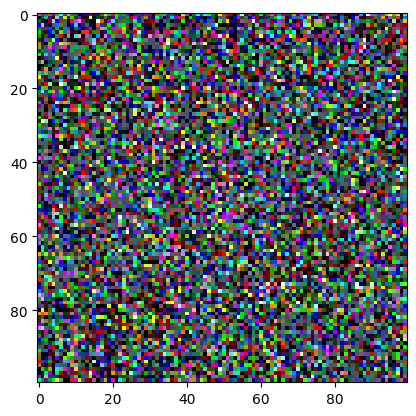

training:  20%|██        | 40/200 [05:44<22:25,  8.41s/it, it=40, psnr=8.4326]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 40.....Test PSNR 8.8409423828125


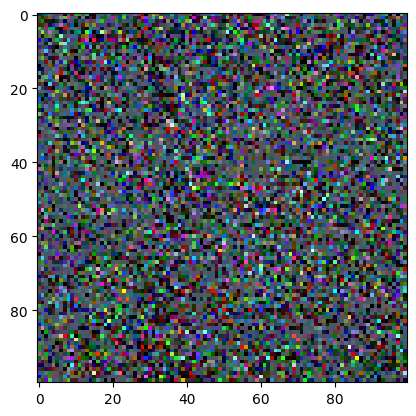

training:  30%|███       | 60/200 [08:34<19:32,  8.38s/it, it=60, psnr=10.4331]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 60.....Test PSNR 11.007447242736816


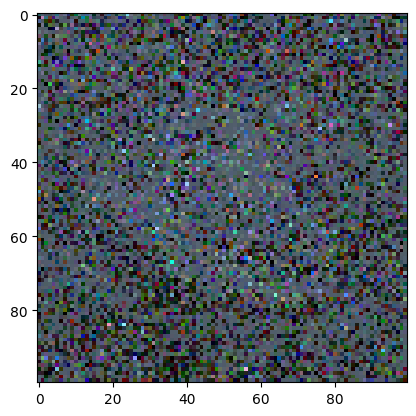

training:  40%|████      | 80/200 [11:23<16:50,  8.42s/it, it=80, psnr=11.9195]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 80.....Test PSNR 12.028453826904297


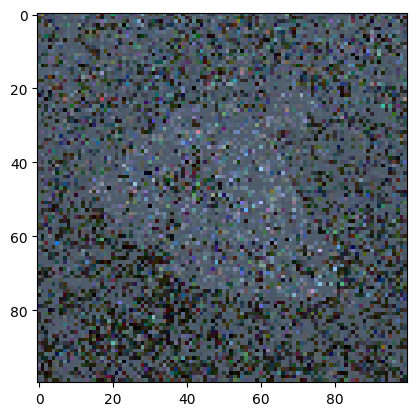

training:  50%|█████     | 100/200 [14:12<13:57,  8.38s/it, it=100, psnr=12.0926]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 100.....Test PSNR 12.404557228088379


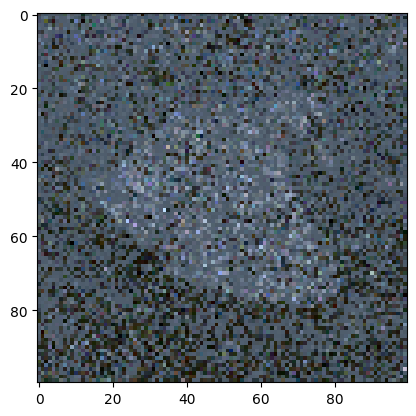

training:  60%|██████    | 120/200 [17:01<11:12,  8.41s/it, it=120, psnr=12.0391]WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 120.....Test PSNR 12.142057418823242


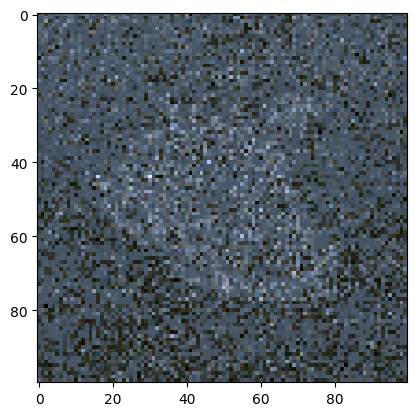

training:  70%|██████▉   | 139/200 [19:37<08:25,  8.29s/it, it=139, psnr=11.3390]

In [ ]:
num_epoch = 200
val_freq = 20
model.train()

train_psnrs_gabor = []
test_psnrs_gabor = []

trainloader = DataLoader(data, batch_size=512, shuffle=True)
progress_loader = tqdm.trange(num_epoch, desc="training", leave=False)


for i in progress_loader:
    for j, (input, gt) in enumerate(trainloader):

        optimizer.zero_grad()
        pred_rgb = model(input)
        loss = criterion(pred_rgb, gt)

        train_psnr = -10 * loss.log10()
        loss.backward()
        optimizer.step()
        progress_loader.set_postfix(it=i,psnr="{:.4f}".format(train_psnr))

    train_psnrs_gabor.append(train_psnr)

    if i % val_freq == 0 and i > 0:
        with torch.no_grad():
            val_rgb = model(data.coords)
            loss = criterion(val_rgb, data.labels)
            psnr = -10 * loss.log10()
            test_psnrs_gabor.append(psnr)
            print("Epoch {}.....Test PSNR {}".format(i, psnr))
            plt.imshow(val_rgb.view(H, W, 3).detach().cpu().numpy())
            plt.show()